In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
from scipy.stats import norm,multivariate_normal
from robust_util import *

import warnings
warnings.filterwarnings("ignore")


In [2]:
parser = argparse.ArgumentParser(description='Covariate Shift')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--epochs-training', type=int, default=75, metavar='N',
                    help='number of epochs in training (default: 10)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')

args, unknown = parser.parse_known_args()


         x0        x1    y       p_x     q_x
0  0.998605  0.390645  0.0  0.000105  0.0001
1  0.845540  0.671970  1.0  0.000271  0.0001
2  0.950920  0.907210  1.0  0.000250  0.0001
3  0.516895  0.526851  1.0  0.000137  0.0001
4  0.668991  0.926782  1.0  0.000251  0.0001


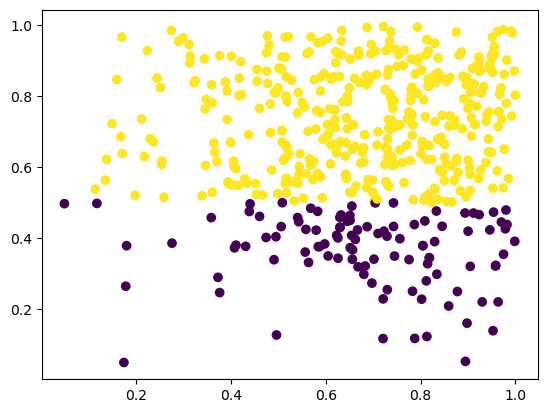

In [3]:
# load train data and visualize. This is synthetic dataset, for details about the dataset creation,\
# you can refer to the synthetic_dataset.ipynb

train_data = pd.read_csv('train_data.csv')
print(train_data.head())
plt.scatter(train_data['x0'],train_data['x1'],c =train_data['y'])

         x0        x1    y       q_x       p_x
0  0.501247  0.843436  1.0  0.000101  0.000188
1  0.166192  0.400763  0.0  0.000010  0.000018
2  0.285126  0.663509  1.0  0.000039  0.000072
3  0.224888  0.578914  1.0  0.000024  0.000044
4  0.250961  0.080730  0.0  0.000003  0.000005


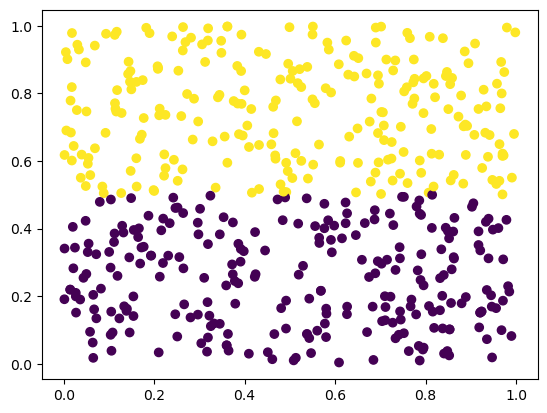

In [4]:
# load test data and visualize

test_data = pd.read_csv('test_data.csv')
print(test_data.head())
plt.scatter(test_data['x0'],test_data['x1'],c =test_data['y'])

In [5]:
# define weight dataset
class WEIGHT_DATA_SET(data.Dataset):
    '''
    dataset class with instance weight 
    '''
    def __init__(self, x, y, weights):
        '''
        weights are same dimensional witi original data
        '''
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)
        self.weights = torch.tensor(weights)

    def __getitem__(self, index):
        img = self.x[index] 
        target = self.y[index]
        weight = self.weights[index]
        return img, target, weight

    def __len__(self):
        return len(self.x)

In [6]:
# dataset dataloader
train_x = np.array(train_data[['x0','x1']])
train_y = np.array(train_data['y'])
train_p_x = np.array(train_data['p_x'])
train_q_x = np.array(train_data['q_x'])

w = my_bound(train_p_x/train_q_x)
weighted_train = WEIGHT_DATA_SET(train_x,train_y,w)


test_x = np.array(test_data[['x0','x1']])
test_y = np.array(test_data['y'])
test_p_x = np.array(test_data['p_x'])
test_q_x = np.array(test_data['q_x'])

w = my_bound(test_p_x/test_q_x)
weighted_test = WEIGHT_DATA_SET(test_x,test_y,w)



# robust regression training
train_model = Net(2,2,2)
train_size = len(train_x)

validate_size = int(0.1*train_size)

validate_loader = data.DataLoader(data.Subset(weighted_train, range(0, validate_size)),
    batch_size=32, shuffle=True)
# 10% validation set
train_loader = data.DataLoader(data.Subset(weighted_train, range(validate_size, train_size)),
    batch_size=32, shuffle=True, )

train_model, Myy, Myx, _, _, _ = train_validate_test(args,args.lr, args.epochs_training, \
                                                     "regression", 'cpu', 'False', train_model,\
                                                     train_loader, None , validate_loader, 4, 0.000, \
                                                     testflag = False)



In [7]:
with torch.no_grad():

    test_loader = data.DataLoader(weighted_test,batch_size=32)
    mse_loss = []
    for x,y,w in test_loader:
        output = train_model(x)
        meanY, varY = ru.predict_regression(w, Myy, Myx, output, mean0, var0)
        mse_loss.append(torch.mean((meanY[0]-y)**2).numpy())
    print('test mse',np.mean(mse_loss))
                        

    
# in this synthetic dataset, the linear version robust regression works better than this version. 



test mse 0.5180281306420653
